## In this notebook, we will
1. Build a NN to predict the reduction potential of molecules.
2. Use tuned hyperparameter values from <font color='blue'>3b.MolRedPot_NN_LearningRateTuning.ipynb</font> and <font color='blue'>3c.MolRedPot_NN_BatchSizeTuning.ipynb</font>
3. Add regularization to the Dense layers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import statsmodels.api as sm
import time
import os

In [2]:
#Keras/TensorFlow
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Softmax
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Keras image processing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [3]:
#Sklearn tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Keras specials
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

## Load csv files into DataFrames
Data was previously split into training and testing sets in <font color='blue'>1.MolRedPot_FeatureEngineering.ipynb</font>

In [4]:
features=pd.read_csv('Data/features_train_scaled.csv')
target=pd.read_csv('Data/target_train.csv')['ERed']

In [5]:
print('Feature matrix shape: ',features.shape)
print('Target property shape: ',target.shape)

Feature matrix shape:  (4353, 32)
Target property shape:  (4353,)


In [6]:
features=tf.convert_to_tensor(features,dtype=tf.float64)
target=tf.convert_to_tensor(target,dtype=tf.float64)

In [7]:
num_dens_layers=4     
n_nodes=[64, 32,16, 1]
learning_rate=1e-3

model = Sequential()
model.add(Dense(n_nodes[0], kernel_initializer='normal',input_dim = features.shape[1], activation='relu')) # first hidden layer
# model.add(Dropout(0.5))
for i in range(1,num_dens_layers): # loop through the rest of hidden layers
    model.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))    

model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
55/55 [==============================] - 1s 8ms/step - loss: 1.0046 - mean_absolute_error: 1.0046 - val_loss: 0.3228 - val_mean_absolute_error: 0.3228 - lr: 0.0010
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.1848 - mean_absolute_error: 0.1848 - val_loss: 0.1324 - val_mean_absolute_error: 0.1324 - lr: 0.0010
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.1187 - mean_absolute_error: 0.1187 - val_loss: 0.1086 - val_mean_absolute_error: 0.1086 - lr: 0.0010
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0957 - mean_absolute_error: 0.0957 - val_loss: 0.0941 - val_mean_absolute_error: 0.0941 - lr: 0.0010
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0854 - mean_absolute_error: 0.0854 - val_loss: 0.0840 - val_mean_absolute_error: 0.0840 - lr: 0.0010
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0782 - mean_absolute_error: 0.0782 - val_loss: 0.08

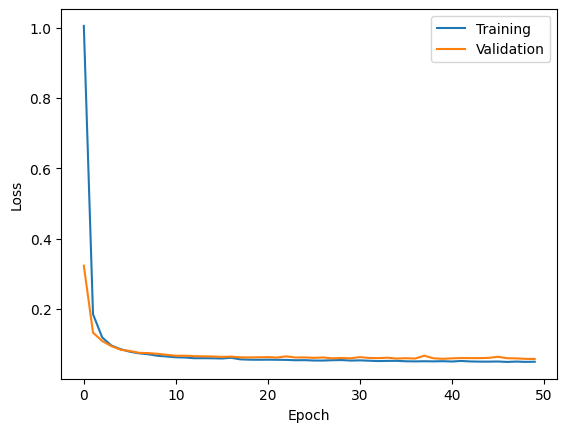

In [8]:
%%time

batch_size=64

with tf.device('/cpu:0'):

    redlr=ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.9, patience=5, min_lr=0, verbose=1)

    history=model.fit(features, target, epochs=50, batch_size=batch_size, validation_split = 0.2, callbacks=redlr, verbose=True)

    train_err=history.history['mean_absolute_error']

    val_err=history.history['val_mean_absolute_error']

    plt.figure()
    plt.plot(train_err, label='Training')
    plt.plot(val_err, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

137/137 [==============================] - 0s 1ms/step


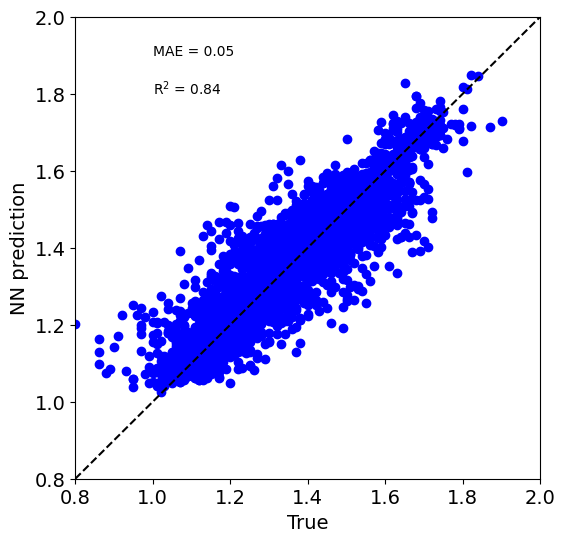

In [9]:
target_nn=model.predict(features)
train_mae=mean_absolute_error(target,target_nn)
train_rmse=np.sqrt(mean_squared_error(target,target_nn))
train_r2=r2_score(target,target_nn)

plt.figure(figsize=(6,6))
plt.scatter(target,target_nn,c='b')
plt.plot([0.8,2],[0.8,2],ls='--',c='k')
plt.xlim([0.8,2])
plt.ylim([0.8,2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('NN prediction',fontsize=14)
plt.text(1,1.9,'MAE = '+str(np.round(train_mae,3)))
plt.text(1,1.8,'R$^2$ = '+str(np.round(train_r2,3)))
plt.show()

After hyperparameter tuning: 
1. The training MAE of the feed forward NN is reduced from 58 meV to 50 meV.
2. The training R2 of the feed forward NN improves fromeduced from 0.807 to 0.840 meV.

The unoptimised model is described in <font color=blue>3.MolRedPot_NN.ipynb</font>

## Impact of weight regularization

## L2 regularization

In [10]:
num_dens_layers=4     
n_nodes=[64, 32,16, 1]
learning_rate=1e-3

model_reg = Sequential()
model_reg.add(Dense(n_nodes[0], kernel_initializer='normal',input_dim = features.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001))) # first hidden layer
# model.add(Dropout(0.5))
for i in range(1,num_dens_layers): # loop through the rest of hidden layers
    model_reg.add(Dense(n_nodes[i], kernel_initializer='normal',activation='relu'))    

model_reg.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
55/55 [==============================] - 1s 5ms/step - loss: 1.0562 - mean_absolute_error: 1.0509 - val_loss: 0.2964 - val_mean_absolute_error: 0.2879 - lr: 0.0010
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.1895 - mean_absolute_error: 0.1812 - val_loss: 0.1352 - val_mean_absolute_error: 0.1270 - lr: 0.0010
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.1229 - mean_absolute_error: 0.1148 - val_loss: 0.1130 - val_mean_absolute_error: 0.1051 - lr: 0.0010
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.1009 - mean_absolute_error: 0.0931 - val_loss: 0.0971 - val_mean_absolute_error: 0.0895 - lr: 0.0010
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.0898 - mean_absolute_error: 0.0824 - val_loss: 0.0884 - val_mean_absolute_error: 0.0813 - lr: 0.0010
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.0823 - mean_absolute_error: 0.0753 - val_loss: 0.08

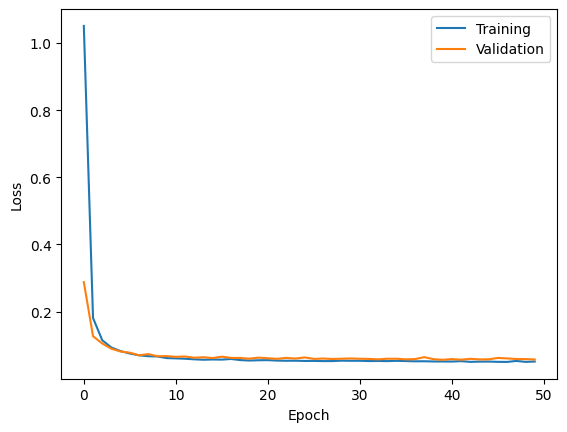

In [11]:
%%time

batch_size=64

with tf.device('/cpu:0'):

    redlr=ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.9, patience=5, min_lr=0, verbose=1)

    history=model_reg.fit(features, target, epochs=50, batch_size=batch_size, validation_split = 0.2, callbacks=redlr, verbose=True)

    train_err=history.history['mean_absolute_error']

    val_err=history.history['val_mean_absolute_error']

    plt.figure()
    plt.plot(train_err, label='Training')
    plt.plot(val_err, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

137/137 [==============================] - 0s 1ms/step


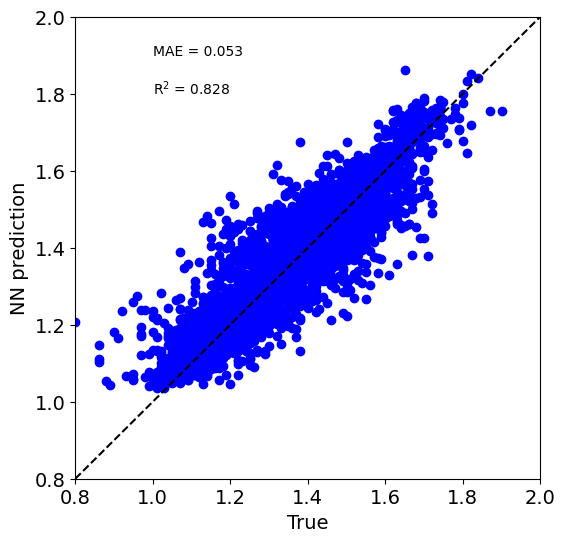

In [12]:
target_nn=model_reg.predict(features)
train_mae=mean_absolute_error(target,target_nn)
train_rmse=np.sqrt(mean_squared_error(target,target_nn))
train_r2=r2_score(target,target_nn)

plt.figure(figsize=(6,6))
plt.scatter(target,target_nn,c='b')
plt.plot([0.8,2],[0.8,2],ls='--',c='k')
plt.xlim([0.8,2])
plt.ylim([0.8,2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('True',fontsize=14)
plt.ylabel('NN prediction',fontsize=14)
plt.text(1,1.9,'MAE = '+str(np.round(train_mae,3)))
plt.text(1,1.8,'R$^2$ = '+str(np.round(train_r2,3)))
plt.show()

Adding L2 regularization marginlly reduces model performance. 
1. The training MAE of the feed forward NN increases from 50 meV to 52 meV.
2. The training R2 of the feed forward NN reduces from 0.840 to 0.836 meV.

## Save final NN model

Final model characteristics:
1. learning rate = 1e-3
2. batch size = 64

In [13]:
!mkdir -p NN_model
model.save('Models/NN_model_tuned/')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file NN_model already exists.
Error occurred while processing: NN_model.


INFO:tensorflow:Assets written to: Models/NN_model_tuned/assets


In [15]:
os.listdir('Models/NN_model_tuned')

['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']

In [16]:
NN_model = tf.keras.models.load_model('Models/NN_model_tuned/')

# Check its architecture
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


## Save NN model and weights as HDF5

In [17]:
model_json = model.to_json()
with open("model_tuned.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_tuned.h5")
print("Saved model to disk")

Saved model to disk
